# 3D image classification from CT scans

**Author:** [exonys](https://github.com/ezsx)<br>
**Date created:** 2023/12/19<br>
**Last modified:** 2020/12/19<br>
**Description:** Train a 3D convolutional neural network to predict presence of pneumonia.

**Stock project** [3D image classification from CT scans](https://keras.io/examples/vision/3D_image_classification/)
**Original author:** [Hasib Zunair](https://twitter.com/hasibzunair)<br>

## Introduction

This example will show the steps needed to build a 3D convolutional neural network (CNN)
to predict the presence of viral pneumonia in computer tomography (CT) scans. 2D CNNs are
commonly used to process RGB images (3 channels). A 3D CNN is simply the 3D
equivalent: it takes as input a 3D volume or a sequence of 2D frames (e.g. slices in a CT scan),
3D CNNs are a powerful model for learning representations for volumetric data.

## References

- [A survey on Deep Learning Advances on Different 3D DataRepresentations](https://arxiv.org/pdf/1808.01462.pdf)
- [VoxNet: A 3D Convolutional Neural Network for Real-Time Object Recognition](https://www.ri.cmu.edu/pub_files/2015/9/voxnet_maturana_scherer_iros15.pdf)
- [FusionNet: 3D Object Classification Using MultipleData Representations](http://3ddl.cs.princeton.edu/2016/papers/Hegde_Zadeh.pdf)
- [Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction](https://arxiv.org/abs/2007.13224)

## Setup

In [45]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau




In [2]:
# Тестим наличие видиокарты
from tensorflow.python.client import device_lib
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(tf.config.experimental.get_memory_info("GPU:0")["current"])
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('False')

0
1 Physical GPUs, 1 Logical GPUs


2023-12-18 07:18:35.882039: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 07:18:36.948765: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 07:18:36.948865: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 07:18:36.960543: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 07:18:36.960612: I external/local_xla/xla/stream_executor

## Downloading the MosMedData: Chest CT Scans with COVID-19 Related Findings

In this example, we use a subset of the
[MosMedData: Chest CT Scans with COVID-19 Related Findings](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1).
This dataset consists of lung CT scans with COVID-19 related findings, as well as without such findings.

We will be using the associated radiological findings of the CT scans as labels to build
a classifier to predict presence of viral pneumonia.
Hence, the task is a binary classification problem.

In [ ]:
# Download url of normal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

# Download url of abnormal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

# Make a directory to store the data.
os.makedirs("MosMedData")

# Unzip data in the newly created directory.
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

## Loading data and preprocessing

The files are provided in Nifti format with the extension .nii. To read the
scans, we use the `nibabel` package.
You can install the package via `pip install nibabel`. CT scans store raw voxel
intensity in Hounsfield units (HU). They range from -1024 to above 2000 in this dataset.
Above 400 are bones with different radiointensity, so this is used as a higher bound. A threshold
between -1000 and 400 is commonly used to normalize CT scans.

To process the data, we do the following:

* We first rotate the volumes by 90 degrees, so the orientation is fixed
* We scale the HU values to be between 0 and 1.
* We resize width, height and depth.

Here we define several helper functions to process the data. These functions
will be used when building training and validation datasets.

In [3]:

import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


Let's read the paths of the CT scans from the class directories.

In [4]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))


CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


## Build train and validation datasets
Read the scans from the class directories and assign labels. Downsample the scans to have
shape of 128x128x64. Rescale the raw HU values to the range 0 to 1.
Lastly, split the dataset into train and validation subsets.

In [5]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
from tqdm import tqdm

print("Processing Scans")
abnormal_scans = np.array([process_scan(path) for path in tqdm(abnormal_scan_paths, desc="Processing Abnormal Scans")])
normal_scans = np.array([process_scan(path) for path in tqdm(normal_scan_paths, desc="Processing Normal Scans")])

abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Calculate the indices for an 80/20 split
index_abnormal = int(0.8 * len(abnormal_scans))
index_normal = int(0.8 * len(normal_scans))

# Splitting the data for 80/20 training and validation
x_train = np.concatenate((abnormal_scans[:index_abnormal], normal_scans[:index_normal]), axis=0)
y_train = np.concatenate((abnormal_labels[:index_abnormal], normal_labels[:index_normal]), axis=0)
x_val = np.concatenate((abnormal_scans[index_abnormal:], normal_scans[index_normal:]), axis=0)
y_val = np.concatenate((abnormal_labels[index_abnormal:], normal_labels[index_normal:]), axis=0)

print("Number of samples in train and validation are %d and %d." % (x_train.shape[0], x_val.shape[0]))


Processing Scans


Processing Normal Scans: 100%|████████████████████████████████████████████████████████| 100/100 [05:28<00:00,  3.28s/it]


Number of samples in train and validation are 160 and 40.


## Data augmentation

The CT scans also augmented by rotating at random angles during training. Since
the data is stored in rank-3 tensors of shape `(samples, height, width, depth)`,
we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on
the data. The new shape is thus `(samples, height, width, depth, 1)`. There are
different kinds of preprocessing and augmentation techniques out there,
this example shows a few simple ones to get started.

In [1]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


2023-12-21 07:54:20.943073: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 07:54:20.943153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 07:54:20.944365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 07:54:20.952146: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 07:54:21.996810: W tensorflow/compiler/tf2

While defining the train and validation data loader, the training data is passed through
and augmentation function which randomly rotates volume at different angles. Note that both
training and validation data are already rescaled to have values between 0 and 1.

Dimension of the CT scan is: (128, 128, 64, 1)


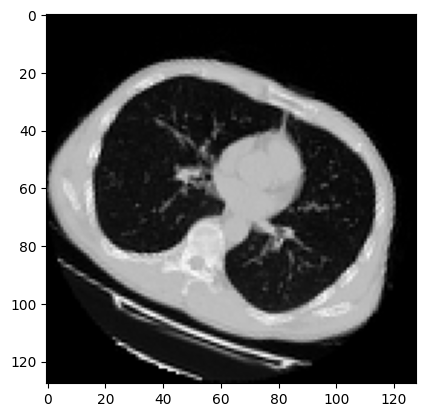

In [20]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")


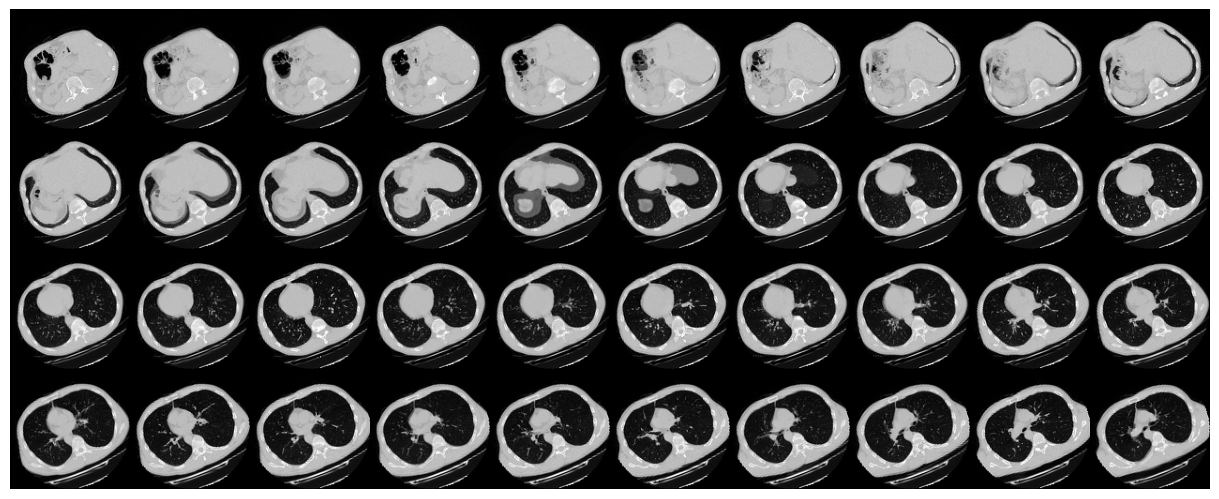

In [22]:

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [2]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
print(f"current batch_size:{batch_size}")

NameError: name 'x_train' is not defined

Visualize an augmented CT scan.

Since a CT scan has many slices, let's visualize a montage of the slices.

## Define a 3D convolutional neural network

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

In [84]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def attention_module(inputs, filters):
    """Attention module to focus on important features"""
    x = layers.Conv3D(filters, kernel_size=1, strides=1, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('sigmoid')(x)
    return layers.multiply([inputs, x])

def get_model(width=128, height=128, depth=64):
    inputs = keras.Input((width, height, depth, 1))

    # Adjusted first convolutional layer
    x = layers.Conv3D(32, kernel_size=3, strides=(2, 2, 2), activation='relu', padding='same')(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = attention_module(x, 32)

    # Second convolutional layer with dropout
    x = layers.Conv3D(64, kernel_size=3, strides=(2, 2, 2), activation='relu', padding='same')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)  # Increased dropout
    x = attention_module(x, 64)

    # Third convolutional layer with increased filters
    x = layers.Conv3D(128, kernel_size=3, strides=(1, 1, 1), activation='relu', padding='same')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = attention_module(x, 128)

    # Global Average Pooling followed by Dense layers
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(512, activation='relu')(x)  # Increased dense layer size
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name="enhanced_attention_3dcnn")
    return model

# Build model
model = get_model(width=128, height=128, depth=64)
model.summary()


Model: "enhanced_attention_3dcnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 128, 128, 64, 1)]    0         []                            
                                                                                                  
 conv3d_140 (Conv3D)         (None, 64, 64, 32, 32)       896       ['input_33[0][0]']            
                                                                                                  
 max_pooling3d_66 (MaxPooli  (None, 32, 32, 16, 32)       0         ['conv3d_140[0][0]']          
 ng3D)                                                                                            
                                                                                                  
 batch_normalization_118 (B  (None, 32, 32, 16, 32)       128       ['max_p

## Train model

In [86]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=50000, decay_rate=0.9, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=20)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
80/80 - 35s - loss: 0.6963 - acc: 0.4563 - val_loss: 0.7038 - val_acc: 0.5000 - 35s/epoch - 433ms/step
Epoch 2/100
80/80 - 25s - loss: 0.6870 - acc: 0.5813 - val_loss: 0.7786 - val_acc: 0.5000 - 25s/epoch - 312ms/step
Epoch 3/100
80/80 - 25s - loss: 0.6754 - acc: 0.6438 - val_loss: 1.0401 - val_acc: 0.5000 - 25s/epoch - 315ms/step
Epoch 4/100
80/80 - 26s - loss: 0.6661 - acc: 0.6000 - val_loss: 1.4050 - val_acc: 0.5000 - 26s/epoch - 331ms/step
Epoch 5/100
80/80 - 27s - loss: 0.6806 - acc: 0.5688 - val_loss: 1.4045 - val_acc: 0.5000 - 27s/epoch - 332ms/step
Epoch 6/100
80/80 - 26s - loss: 0.6653 - acc: 0.6125 - val_loss: 1.2682 - val_acc: 0.5000 - 26s/epoch - 322ms/step
Epoch 7/100
80/80 - 25s - loss: 0.6726 - acc: 0.5688 - val_loss: 1.0580 - val_acc: 0.5000 - 25s/epoch - 313ms/step
Epoch 8/100
80/80 - 25s - loss: 0.6445 - acc: 0.6313 - val_loss: 1.0058 - val_acc: 0.5000 - 25s/epoch - 316ms/step
Epoch 9/100
80/80 - 25s - loss: 0.6431 - acc: 0.6750 - val_loss: 0.8069 - val_ac

It is important to note that the number of samples is very small (only 200) and we don't
specify a random seed. As such, you can expect significant variance in the results. The full dataset
which consists of over 1000 CT scans can be found [here](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1). Using the full
dataset, an accuracy of 83% was achieved. A variability of 6-7% in the classification
performance is observed in both cases.

## Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.
Since the validation set is class-balanced, accuracy provides an unbiased representation
of the model's performance.

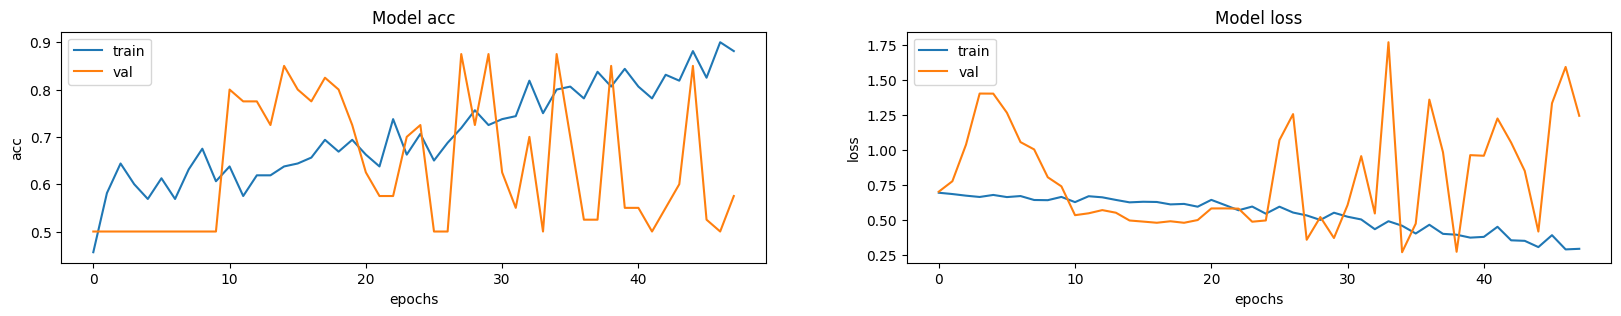

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Make predictions on a single CT scan

In [88]:

# Load best weights.
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )
    print("And this is " + str(y_val[0]))


datagen = ImageDataGenerator()
generator = datagen.flow(x_val, batch_size=batch_size, shuffle=False)

y_pred = model.predict_generator(generator, steps=np.ceil(len(x_val) / batch_size))


y_pred_binary = (y_pred > 0.5).astype(int)


# метрики
accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


model.save("iz_3_buffed_image_save", save_format="tf")

plt.show()

1/1 [==============================] - 1s 598ms/step
This model is 34.25 percent confident that CT scan is normal
And this is 1
This model is 65.75 percent confident that CT scan is abnormal
And this is 1


/home/ezsx/anaconda3/envs/tensorflow_gpu/lib/python3.11/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (40, 128, 128, 64) (64 channels).
  warnings.warn('NumpyArrayIterator is set to use the '
/tmp/ipykernel_53821/4108596487.py:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(generator, steps=np.ceil(len(x_val) / batch_size))


Accuracy: 0.875
Precision: 0.8571428571428571
Recall: 0.9
INFO:tensorflow:Assets written to: iz_3_buffed_image_save/assets


INFO:tensorflow:Assets written to: iz_3_buffed_image_save/assets
